In [1]:
# Configure Loguru to INFO in Jupyter
import sys
from loguru import logger
from ase.build import molecule
from rdkit import Chem
from rdkit.Chem import AllChem

from neural_optimiser.optimisers import BFGS
from neural_optimiser.calculators import RandomCalculator
from neural_optimiser.conformers import ConformerBatch, Conformer
from neural_optimiser.datasets.base import ConformerDataset, ConformerDataLoader

In [2]:
logger.remove()  # avoid duplicate logs across re-runs
logger.add(sys.stdout, level="INFO")

1

## Run a Batched BFGS Optimisation

In [3]:
# Create a batch of molecules (each becomes a conformer)
atoms_list = [molecule("H2O"), molecule("NH3"), molecule("CH3OCH3")]
batch = ConformerBatch.from_ase(atoms_list)

# Configure optimiser and attach a calculator that provides forces
optimiser = BFGS(steps=100, fmax=0.05, fexit=500.0, max_step=0.04)
optimiser.calculator = RandomCalculator()

# Run optimisation
converged = optimiser.run(batch)
print("All Converged:", converged)
for i, (conv, nsteps) in enumerate(zip(batch.converged, batch.converged_step)):
    print(f"Conformer {i}: Converged: {conv}, On step {nsteps}")

# Trajectory [T, N, 3] and converged coordinates [N, 3]
print("pos_dt shape:", tuple(batch.pos_dt.shape))
print("pos shape:", tuple(batch.pos.shape))

atom_types
pos
2025-10-15 10:19:33.900 | INFO     | neural_optimiser.optimisers.base:run:122 - Starting BFGS: nconf=3, natoms=16, steps=100, fmax=0.05, fexit=500.0, max_step=0.04


2025-10-15 10:19:33.910 | INFO     | neural_optimiser.optimisers.base:_should_exit:297 - Step 10: 0/3 conformers converged.
2025-10-15 10:19:33.918 | INFO     | neural_optimiser.optimisers.base:_should_exit:297 - Step 20: 0/3 conformers converged.
2025-10-15 10:19:33.925 | INFO     | neural_optimiser.optimisers.base:_should_exit:297 - Step 30: 0/3 conformers converged.
2025-10-15 10:19:33.930 | INFO     | neural_optimiser.optimisers.base:_should_exit:297 - Step 40: 0/3 conformers converged.
2025-10-15 10:19:33.937 | INFO     | neural_optimiser.optimisers.base:_should_exit:297 - Step 50: 0/3 conformers converged.
2025-10-15 10:19:33.941 | INFO     | neural_optimiser.optimisers.base:_should_exit:297 - Step 60: 0/3 conformers converged.
2025-10-15 10:19:33.946 | INFO     | neural_optimiser.optimisers.base:_should_exit:297 - Step 70: 0/3 conformers converged.
2025-10-15 10:19:33.950 | INFO     | neural_optimiser.optimisers.base:_should_exit:297 - Step 80: 0/3 conformers converged.
2025-10-

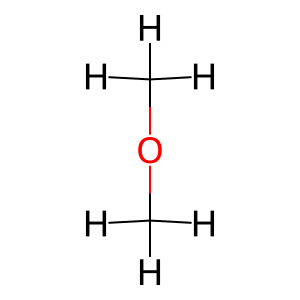

In [7]:
# View the first and last step of the first conformer
initial = batch.conformer(idx=2, step=0).plot(dim=3)
initial

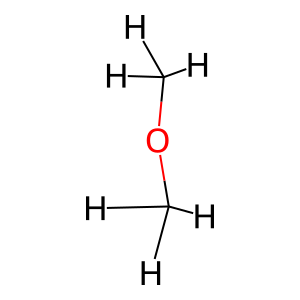

In [8]:
final = batch.conformer(idx=2, step=-1).plot(dim=3)
final

## Run a Larger BFGS Optimisation using the ConformerDataLoader

In [9]:
# Build a pool of conformers from RDKit molecules
smiles_list = ["CCO", "CC", "CCN"]
mols = []
for smiles in smiles_list:
    m = Chem.AddHs(Chem.MolFromSmiles(smiles))
    AllChem.EmbedMultipleConfs(m, numConfs=10, useExpTorsionAnglePrefs=True, useBasicKnowledge=True)
    mols.append(m)

big_batch = ConformerBatch.from_rdkit(mols)  # creates one Conformer per RDKit conformer

# Dataset/DataLoader -> yields ConformerBatch
dataset = ConformerDataset(big_batch.to_data_list())
dataloader = ConformerDataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

# Configure optimiser and attach a calculator that provides forces
optimiser = BFGS(steps=10, fmax=0.05, fexit=500.0, max_step=0.04)
optimiser.calculator = RandomCalculator()

for batch in dataloader:
    optimiser.run(batch) 

atom_types
pos
atom_types
pos
2025-10-15 10:19:47.307 | INFO     | neural_optimiser.optimisers.base:run:122 - Starting BFGS: nconf=8, natoms=75, steps=10, fmax=0.05, fexit=500.0, max_step=0.04
2025-10-15 10:19:47.320 | INFO     | neural_optimiser.optimisers.base:_should_exit:297 - Step 10: 0/8 conformers converged.
2025-10-15 10:19:47.321 | INFO     | neural_optimiser.optimisers.base:_should_exit:322 - Step limit reached: 10 steps.
2025-10-15 10:19:47.321 | INFO     | neural_optimiser.optimisers.base:_run:165 - Exiting after step 10: converged=False
atom_types
pos
2025-10-15 10:19:47.323 | INFO     | neural_optimiser.optimisers.base:run:122 - Starting BFGS: nconf=8, natoms=72, steps=10, fmax=0.05, fexit=500.0, max_step=0.04
2025-10-15 10:19:47.332 | INFO     | neural_optimiser.optimisers.base:_should_exit:297 - Step 10: 0/8 conformers converged.
2025-10-15 10:19:47.332 | INFO     | neural_optimiser.optimisers.base:_should_exit:322 - Step limit reached: 10 steps.
2025-10-15 10:19:47.332

## Data Containers

### Conformers

In [10]:
# From ASE
atoms = molecule("H2O")
conf1 = Conformer.from_ase(atoms, smiles="O")

print(type(conf1).__name__)
print("atom_types:", conf1.atom_types.shape)  # [n_atoms]
print("pos:", conf1.pos.shape)                # [n_atoms, 3]
print("smiles:", conf1.smiles)

# Convert back to ASE
atoms2 = conf1.to_ase()
print("ASE atoms:", atoms2.get_chemical_formula(), atoms2.positions.shape)

Conformer
atom_types: torch.Size([3])
pos: torch.Size([3, 3])
smiles: O
ASE atoms: H2O (3, 3)


In [11]:
# From RDKit
mol = Chem.MolFromSmiles("CCO")
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol, AllChem.ETKDG())
conf2 = Conformer.from_rdkit(mol)

# Convert back to RDKit (returns a Mol with one 3D conformer)
mol2 = conf2.to_rdkit()
print("RDKit confs:", mol2.GetNumConformers())

RDKit confs: 1


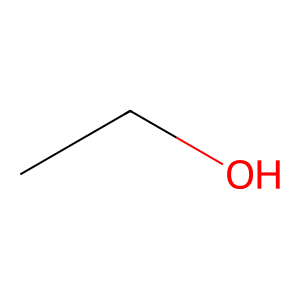

In [12]:
conf2.plot(dim=2)

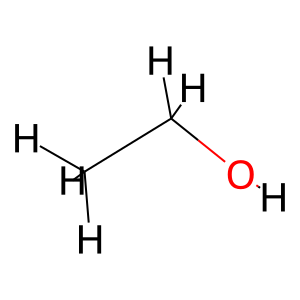

In [13]:
conf2.plot(dim=3)

### ConformerBatch

In [15]:
# Build from ASE
atoms_list = [molecule("H2O"), molecule("NH3"), molecule("CH4")]
batch_ase = ConformerBatch.from_ase(atoms_list)
print("ASE batch:", batch_ase.n_molecules, batch_ase.n_conformers, batch_ase.n_atoms)

# Slice a single conformer view
conf0 = batch_ase.conformer(0)
print("conf0 pos:", conf0.pos.shape)

# Indices available on the batch (per-atom)
print("batch index shape:", batch_ase.batch.shape)

atom_types
pos
ASE batch: None 3 12
conf0 pos: torch.Size([3, 3])
batch index shape: torch.Size([12])


In [16]:
# Build from RDKit (multiple conformers per molecule also supported)
def rdkit_with_coords(smiles: str):
    m = Chem.MolFromSmiles(smiles)
    m = Chem.AddHs(m)
    AllChem.EmbedMolecule(m, AllChem.ETKDG())
    return m

mol_list = [rdkit_with_coords("O"), rdkit_with_coords("CCO")]
batch_rd = ConformerBatch.from_rdkit(mol_list)
print("RDKit batch:", batch_rd.n_molecules, batch_rd.n_conformers, batch_rd.n_atoms)

# Build from a list of Conformer objects
c1 = Conformer.from_ase(molecule("H2O"))
c2 = Conformer.from_ase(molecule("NH3"))
batch_list = ConformerBatch.from_data_list([c1, c2])
print("Data list batch:", batch_list.n_molecules, batch_list.n_conformers, batch_list.n_atoms)

atom_types
pos
RDKit batch: 2 2 12
atom_types
pos
Data list batch: None 2 7
